# FinOL
## Tutorial 3: Model Layer

In this tutorial, we will introduce the ``model_layer``  in ``FinOL``. The ``model_layer``  contains a variety of time series models that can be used for OLPS task. These models take as input the data that has been preprocessed by the ``data_layer``  and output portfolio vector for the next period.

Currently, the following time series models are available in the ``model_layer``:

1. DNN
2. RNN
3. LSTM
4. CNN
6. Transformer
7. LSRE-CAAN

Each of these models utilizes the historical data provided by the ``data_layer`` to generate portfolio weights. The output of these models is a set of normalized weights that represent the suggested allocation for each asset in the portfolio.

At ``FinOL``, we are committed to continuously updating and incorporating state-of-the-art data-driven models to keep up with the evolving trends in the financial industry. Our goal is to provide users with a wide range of advanced models to choose from, ensuring they have access to the latest and most effective tools for their OLPS tasks.

In this tutorial, we will delve deeper into ``LSTM`` model, providing practical examples of how to implement and utilize the Model Layer. The content of this tutorial is applicable to all models provided by ``FinOL``.

We first import the ``data_loader``, ``LSTM``, and other necessary packages for Tutorial 3.

In [1]:
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from finol.data_layer.data_loader import *
from finol.model_layer.LSTM import *
from finol.config import *

with open(ROOT_PATH + '/config.py', 'r') as file:
    content = file.read()

content = re.sub(r'(TUTORIAL_MODE\s*=\s*).*', r'\g<1>True', content)
content = re.sub(r'(TUTORIAL_NAME\s*=\s*").*?(")', r'\g<1>' + "TUTORIAL_3" + r'\g<2>', content)

with open(ROOT_PATH + '/config.py', 'w') as file:
    file.write(content)

In ``FinOL``, the code for the ``LSTM.py`` is located in the ``finol.model_layer`` file. The class inherits from the ``nn.Module`` and implements the abstract method ``forward()`` to generate portfolio weights.

**Input**

The input to the ``LSTM.py`` is a tensor of shape [BATCH_SIZE, NUM_ASSETS, NUM_FEATURES_AUGMENTED], where:

BATCH_SIZE is the batch size.
NUM_ASSETS is the number of the assets.
NUM_FEATURES_AUGMENTED is the dimension of the input features.

**Processing**

The ``LSTM.py`` processes the input through the following steps:

1. Input Transformation: [BATCH_SIZE, NUM_ASSETS, NUM_FEATURES_AUGMENTED] -> [BATCH_SIZE, NUM_ASSETS, WINDOW_SIZE, NUM_FEATURES_ORIGINAL] -> [BATCH_SIZE * NUM_ASSETS, WINDOW_SIZE, NUM_FEATURES_ORIGINAL]
2. Temporal Representation Extraction: Process the sequential data using ``nn.lstm`` layer.
3. Decision Making: After processing all the time steps, the LSTM layer produces a final output, model transforms the output to a batch of portfolio weights, which represents the suggested allocation of weights for each asset in the portfolio.

**Output**

The output of the ``LSTM.py`` is a tensor of shape [BATCH_SIZE, NUM_ASSETS], where:

BATCH_SIZE is the batch size.
NUM_ASSETS is the number of the assets.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from finol.config import *

NUM_LAYERS = MODEL_PARAMS.get("LSTM")["NUM_LAYERS"]
HIDDEN_SIZE = MODEL_PARAMS.get("LSTM")["HIDDEN_SIZE"]


class LSTM(nn.Module):
    def __init__(
            self,
            *,
            num_assets,
            num_features_augmented,
            num_features_original,
            window_size,
            **kwargs
    ):
        super().__init__()

        self.num_assets = num_assets
        self.num_features_augmented = num_features_augmented
        self.num_features_original = num_features_original
        self.window_size = window_size

        self.lstm = nn.LSTM(input_size=num_features_original, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        batch_size = x.shape[0]

        """Input Transformation"""
        x = x.view(batch_size, self.num_assets, self.window_size, self.num_features_original)
        x = rearrange(x, 'b m n d -> (b m) n d')
        if SCALER == 'WindowedStandardScaler':
            x = get_WindowedStandardScaler(x)

        """Temporal Representation Extraction"""
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = out[:, -1, :]

        """Final Scores for Assets"""
        out = out.view(batch_size, self.num_assets, HIDDEN_SIZE)
        out = self.fc(out).squeeze(-1)
        # portfolio = F.softmax(out, dim=-1)
        return out

Let's try it with real data. As mentioned previously in Tutorial 2, we first load the dataset for our machine learning model using the ``load_dataset`` function. This function takes care of loading the data from a file, parsing it, and preprocessing it to prepare it for training, validation, and testing. The ``LSTM.py`` expects input data in a specific format.

In [3]:
load_dataset_output = load_dataset()
load_dataset_output

Data Loading: 100%|██████████| 26/26 [00:15<00:00,  1.71it/s]


Successfully loaded 26 Excel file(s):

Data Processing: 100%|██████████| 26/26 [00:37<00:00,  1.45s/it]


{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x16306c7efa0>,
 'val_loader': <torch.utils.data.dataloader.DataLoader at 0x16306c7ecd0>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x16306c7e8b0>,
 'NUM_TRAIN_PERIODS': 3293,
 'NUM_VAL_PERIODS': 1130,
 'NUM_TEST_PERIODS': 1131,
 'NUM_ASSETS': 26,
 'NUM_FEATURES_AUGMENTED': 1430,
 'NUM_FEATURES_ORIGINAL': 143,
 'DETAILED_NUM_FEATURES': {'OHLCV_FEATURES': 5,
  'OVERLAP_FEATURES': 20,
  'MOMENTUM_FEATURES': 40,
  'VOLUME_FEATURES': 3,
  'CYCLE_FEATURES': 7,
  'PRICE_FEATURES': 4,
  'VOLATILITY_FEATURES': 3,
  'PATTERN_FEATURES': 61},
 'WINDOW_SIZE': 10,
 'OVERALL_FEATURE_LIST': ['OHLCV_FEATURES',
  'OVERLAP_FEATURES',
  'MOMENTUM_FEATURES',
  'VOLUME_FEATURES',
  'CYCLE_FEATURES',
  'PRICE_FEATURES',
  'VOLATILITY_FEATURES',
  'PATTERN_FEATURES'],
 'DETAILED_FEATURE_LIST': ['OPEN',
  'HIGH',
  'LOW',
  'CLOSE',
  'VOLUME',
  'BBANDS_UPPER',
  'BBANDS_MIDDLE',
  'BBANDS_LOWER',
  'DEMA',
  'EMA',
  'HT_TRENDLINE'

We then initialize the ``LSTM`` class and specify necessary parameters and iterate over the training data using the ``train_loader`` and perform a forward pass through the model by passing the ``x_data`` tensor to the model's ``forward()`` method. For each batch, we obtain a batch of portfolio weights using the model.

In [17]:
from finol.utils import actual_portfolio_selection
torch.manual_seed(MANUAL_SEED)
model = LSTM(
    num_assets=load_dataset_output['NUM_ASSETS'],
    num_features_augmented=load_dataset_output['NUM_FEATURES_AUGMENTED'],
    num_features_original=load_dataset_output['NUM_FEATURES_ORIGINAL'],
    window_size=load_dataset_output['WINDOW_SIZE']
).to(DEVICE)

train_loader = load_dataset_output['train_loader']

label_list = []
portfolio_list = []
daily_return_list = []
for i, data in enumerate(train_loader, 1):
    x_data, label = data
    for t in range(x_data.shape[0]):
        x_data_t = x_data[t]
        label_t = label[t]
        x_data_t = x_data_t.unsqueeze(0)
        label_t = label_t.unsqueeze(0)

        label_t = label_t.cpu().detach().numpy()
        label_list.append(label_t)

        final_scores = model(x_data_t.float())
        portfolio = actual_portfolio_selection(final_scores)
        portfolio = portfolio.cpu().detach().numpy()
        portfolio_list.append(portfolio)

        daily_return = np.sum(label_t * portfolio)
        daily_return_list.append(daily_return)

daily_cumulative_wealth = np.cumprod(daily_return_list)

In [18]:
portfolio.shape

(1, 26)

At this point, the model has not yet learned any patterns or relationships in the data, and is simply making random investment decisions based on the initial conditions. As shown in the figure below, the portfolio is diversified, with roughly equal investments in all assets during the training set.

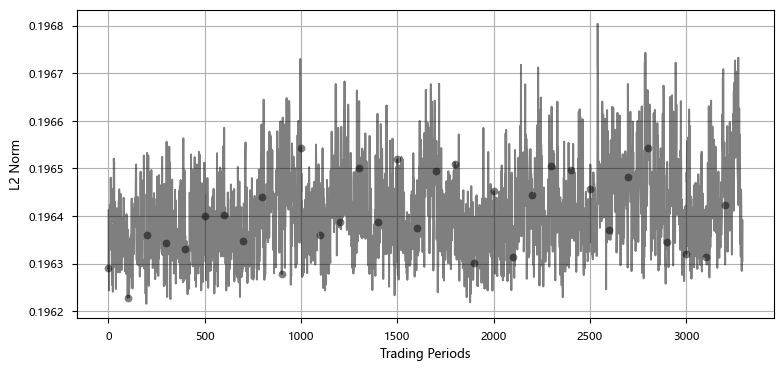

In [19]:
plt.figure(figsize=(9, 4))
l2_norm_list = []
for portfolio in portfolio_list:
    l2_norm = np.linalg.norm(portfolio, ord=2)
    l2_norm_list.append(l2_norm)

plt.xlabel('Trading Periods')
plt.ylabel('L2 Norm')
plt.grid(True)
plt.plot(l2_norm_list, marker=MARKERS[0], color='black', markevery=MARKEVERY*10, alpha=ALPHA)
plt.show()

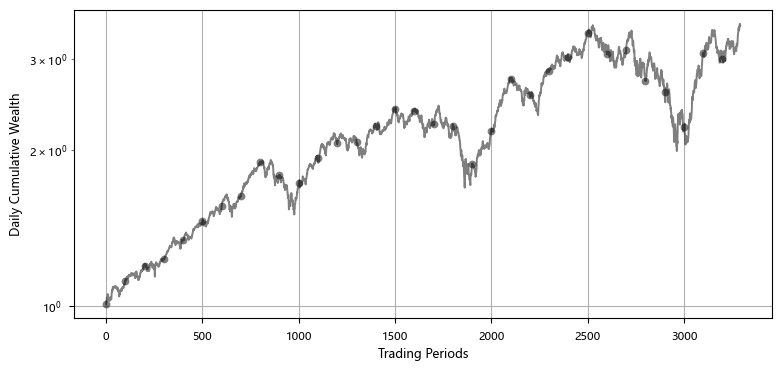

In [20]:
# In-sample daily cumulative wealth
plt.figure(figsize=(9, 4))
plt.plot(daily_cumulative_wealth, marker=MARKERS[0], color='black', markevery=MARKEVERY*10, alpha=ALPHA)
plt.xlabel('Trading Periods')
plt.ylabel('Daily Cumulative Wealth')
plt.yscale('log')
plt.grid(True)
plt.show()

Based on the exploration and verification done in the previous code block, we are now ready to move on to the actual training of the model.

In the next tutorial, we will cover how to define the optimization layers and loss function needed to train the ``LSTM`` model. We will look at how to configure items like the optimizer, learning rate, number of training epochs etc.

With the optimization layers and loss function in place, we will then train the model by running the optimizer on batches of data from our training loader. We can monitor the loss over the training process to check for successful minimization.

Finally, we will evaluate the trained model on our validation set to gauge its performance. Comparing the untrained and trained model outcomes will demonstrate how the learning process has equipped the initial randomized model with the ability to make meaningful decisions based on the dataset.

Transitioning from model initialization, to formally optimizing and training and model is an important next step. The upcoming Tutorial 4 will showcase these key techniques needed to fully realize the potential of our defined ``LSTM`` architecture.